## 1. Preliminary

### 1.1 Context

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Voici [les données](https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P4/2016_Building_Energy_Benchmarking.csv) et [leur source](https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy). Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, **vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation** pour lesquels elles n’ont pas encore été mesurées.

<div class="alert alert-block alert-info">
Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)
</div>

Vous cherchez également à **évaluer l’intérêt de l’"[ENERGY STAR Score](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/interpret-your-results/what)" pour la prédiction d’émissions**, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :
 1) Réaliser une courte analyse exploratoire.
 2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes et erreurs à éviter :

> Douglas : L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées.. 
Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.


### 1.2 Requirements

In [1]:
package_list = ("pandas", "numpy", "matplotlib", "seaborn", "scikit-learn", "mlflow")

In [2]:
!python3 -V

Python 3.10.13


In [3]:
txt = !python3 -m pip freeze
check = lambda i: any([(pack in i) for pack in package_list])
txt = [i for i in txt if check(i)]
txt

['matplotlib==3.8.2',
 'matplotlib-inline==0.1.6',
 'mlflow==2.11.3',
 'numpy @ file:///Users/runner/miniforge3/conda-bld/numpy_1704280780572/work/dist/numpy-1.26.3-cp310-cp310-macosx_11_0_arm64.whl#sha256=f96d0b051b72345dbc317d793b2b34c7c4b7f41b0b791ffc93e820c45ba6a91c',
 'pandas==2.2.0',
 'scikit-learn==1.4.0',
 'seaborn==0.13.2']

### 1.3 Imports

In [4]:
# built in
import os, warnings
import time

# data
import pandas as pd
import numpy as np

# metrics
from sklearn.metrics import mean_squared_error, r2_score

# estimators
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, Perceptron
from sklearn.neural_network import MLPRegressor

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## mlflow
import mlflow
import mlflow.sklearn

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# exceptions
from sklearn.exceptions import ConvergenceWarning

# pipeline et preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer



### 1.4 Graphics and option

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
# warnings.filterwarnings('ignore)
warnings.filterwarnings(action='once')

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='_distutils_hack')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='importlib')

# Ignore ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

<div class="alert alert-block alert-info">
We disable the warnings.</div>

### 1.5 Data

In [7]:
# !tree

In [8]:
# os.listdir()

In [9]:
path="./data/cleaned/"
filename="df_SiteEnergyUseWN_0.csv"

In [10]:
df = pd.read_csv(path+filename)
df.head()

,Neighborhood,GroupedPrimaryPropertyTypes,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),ENERGYSTARScore,DistanceToDowntown,Log_SiteEnergyUseWN(kBtu)
0,DOWNTOWN,Bâtiments d'Hébergement,1927.0,1.0,12.0,88434.0,60.0,0.864611,15.824652
1,DOWNTOWN,Bâtiments d'Hébergement,1996.0,1.0,11.0,88502.0,61.0,0.907278,15.974742
2,DOWNTOWN,Bâtiments d'Hébergement,1969.0,1.0,41.0,759392.0,43.0,1.047606,18.118725
3,DOWNTOWN,Bâtiments d'Hébergement,1926.0,1.0,10.0,61320.0,56.0,1.038057,15.753792
4,DOWNTOWN,Bâtiments d'Hébergement,1980.0,1.0,18.0,113580.0,75.0,1.100255,16.500395


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1379 non-null   object 
 1   GroupedPrimaryPropertyTypes  1379 non-null   object 
 2   YearBuilt                    1379 non-null   float64
 3   NumberofBuildings            1379 non-null   float64
 4   NumberofFloors               1379 non-null   float64
 5   PropertyGFABuilding(s)       1379 non-null   float64
 6   ENERGYSTARScore              924 non-null    float64
 7   DistanceToDowntown           1379 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)    1379 non-null   float64
dtypes: float64(7), object(2)
memory usage: 97.1+ KB


In [12]:
path_original="./data/source/"
filename_original="2016_Building_Energy_Benchmarking.csv"

In [13]:
df_original = pd.read_csv(path_original+filename_original)

In [14]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

## 2. Data Preparation

### 2.1 Stratification

In [15]:
# Creating quartiles in df_original
df_original['EnergyUseQuartiles'] = pd.qcut(df_original['SiteEUIWN(kBtu/sf)'], q=10, labels=False)

# Merging the quartile information with df
# Make sure df_original and df are aligned (you might need to merge based on a shared identifier if not)
# For this example, I'm assuming they're aligned based on the index
df['EnergyUseQuartiles'] = df_original['EnergyUseQuartiles']

df = df.dropna(subset=['EnergyUseQuartiles'])
df.info()

# Preparing for the stratified split
X = df.drop(columns=['Log_SiteEnergyUseWN(kBtu)', 'EnergyUseQuartiles'])  # Drop the target and quartile columns
y = df['Log_SiteEnergyUseWN(kBtu)']  # Replace this with the name of your actual target variable
stratify_col = df['EnergyUseQuartiles']

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 0 to 1378
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1376 non-null   object 
 1   GroupedPrimaryPropertyTypes  1376 non-null   object 
 2   YearBuilt                    1376 non-null   float64
 3   NumberofBuildings            1376 non-null   float64
 4   NumberofFloors               1376 non-null   float64
 5   PropertyGFABuilding(s)       1376 non-null   float64
 6   ENERGYSTARScore              922 non-null    float64
 7   DistanceToDowntown           1376 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)    1376 non-null   float64
 9   EnergyUseQuartiles           1376 non-null   float64
dtypes: float64(8), object(2)
memory usage: 118.2+ KB


In [16]:
y.head()

0    15.824652
1    15.974742
2    18.118725
3    15.753792
4    16.500395
Name: Log_SiteEnergyUseWN(kBtu), dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 0 to 1378
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1376 non-null   object 
 1   GroupedPrimaryPropertyTypes  1376 non-null   object 
 2   YearBuilt                    1376 non-null   float64
 3   NumberofBuildings            1376 non-null   float64
 4   NumberofFloors               1376 non-null   float64
 5   PropertyGFABuilding(s)       1376 non-null   float64
 6   ENERGYSTARScore              922 non-null    float64
 7   DistanceToDowntown           1376 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)    1376 non-null   float64
 9   EnergyUseQuartiles           1376 non-null   float64
dtypes: float64(8), object(2)
memory usage: 118.2+ KB


## 3. Gradient boosting

In [18]:
# Define the Gradient Boosting parameters
gb_params = {'n_estimators': 150, 'learning_rate': 0.1, 
             'max_depth': 2, 'min_samples_split': 20, 
             'min_samples_leaf': 10, 'max_features': 0.75}


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=stratify_col)


# Preprocessing pipelines for numeric and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# pipe_trans_num = Pipeline(steps=[('scaler', StandardScaler())])
# pipe_trans_cat = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', pipe_trans_num, numeric_features),
#         ('cat', pipe_trans_cat, categorical_features)
#         ])

# # Complete pipeline
# k_val = 15
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ("imputer", KNNImputer(n_neighbors=k_val)),
#     ("model", GradientBoostingRegressor(**gb_params))
# ])

k_val = 15
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=k_val))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder())
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(**gb_params))
])


pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("The R2 score on test set: {:.4f}".format(test_r2))


The R2 score on test set: 0.7480


## Plot training deviance

Finally, we will visualize the results. To do that we will first compute the
test set deviance and then plot it against boosting iterations.


In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276 entries, 473 to 1067
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 276 non-null    object 
 1   GroupedPrimaryPropertyTypes  276 non-null    object 
 2   YearBuilt                    276 non-null    float64
 3   NumberofBuildings            276 non-null    float64
 4   NumberofFloors               276 non-null    float64
 5   PropertyGFABuilding(s)       276 non-null    float64
 6   ENERGYSTARScore              174 non-null    float64
 7   DistanceToDowntown           276 non-null    float64
dtypes: float64(6), object(2)
memory usage: 19.4+ KB


In [20]:
pipeline.fit(X_train, y_train)

# Get the preprocessed data for both train and test sets
X_train_preprocessed = pipeline.named_steps["preprocessor"].transform(X_train)
X_test_preprocessed = pipeline.named_steps["preprocessor"].transform(X_test)


# Get the model from the pipeline
reg = pipeline.named_steps["model"]

# Calculate MSE for each stage
test_score = np.zeros((gb_params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test_preprocessed)):
    test_score[i] = r2_score(y_test, y_pred)

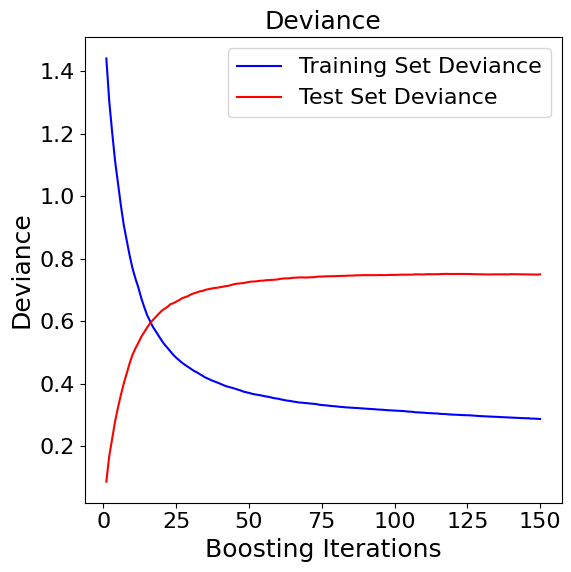

In [21]:
fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(gb_params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(gb_params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

## Plot feature importance

<div class="alert alert-danger"><h4>Warning</h4><p>Careful, impurity-based feature importances can be misleading for
   **high cardinality** features (many unique values). As an alternative,
   the permutation importances of ``reg`` can be computed on a
   held out test set. See `permutation_importance` for more details.</p></div>

For this example, the impurity-based and permutation methods identify the
same 2 strongly predictive features but not in the same order. The third most
predictive feature, "bp", is also the same for the 2 methods. The remaining
features are less predictive and the error bars of the permutation plot
show that they overlap with 0.



In [22]:
from sklearn.inspection import permutation_importance

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1376 entries, 0 to 1378
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighborhood                 1376 non-null   object 
 1   GroupedPrimaryPropertyTypes  1376 non-null   object 
 2   YearBuilt                    1376 non-null   float64
 3   NumberofBuildings            1376 non-null   float64
 4   NumberofFloors               1376 non-null   float64
 5   PropertyGFABuilding(s)       1376 non-null   float64
 6   ENERGYSTARScore              922 non-null    float64
 7   DistanceToDowntown           1376 non-null   float64
 8   Log_SiteEnergyUseWN(kBtu)    1376 non-null   float64
 9   EnergyUseQuartiles           1376 non-null   float64
dtypes: float64(8), object(2)
memory usage: 118.2+ KB


In [24]:
# Get the column names after transformation
if isinstance(preprocessor, ColumnTransformer):
    # If preprocessor is a ColumnTransformer
    preprocessed_feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)
elif isinstance(preprocessor, Pipeline) and isinstance(preprocessor.named_steps["preprocessor"], ColumnTransformer):
    # If preprocessor is a Pipeline containing a ColumnTransformer
    preprocessed_feature_names = preprocessor.named_steps["preprocessor"].get_feature_names_out(input_features=X_train.columns)
else:
    # If preprocessor doesn't have a get_feature_names_out method, you can manually extract column names
    preprocessed_feature_names = X_train.columns.tolist()
    
feature_names = preprocessed_feature_names

In [25]:
feature_names

array(['num__YearBuilt', 'num__NumberofBuildings', 'num__NumberofFloors',
       'num__PropertyGFABuilding(s)', 'num__ENERGYSTARScore',
       'num__DistanceToDowntown', 'cat__Neighborhood_BALLARD',
       'cat__Neighborhood_CENTRAL', 'cat__Neighborhood_DELRIDGE',
       'cat__Neighborhood_DOWNTOWN', 'cat__Neighborhood_EAST',
       'cat__Neighborhood_GREATER DUWAMISH',
       'cat__Neighborhood_LAKE UNION',
       'cat__Neighborhood_MAGNOLIA / QUEEN ANNE',
       'cat__Neighborhood_NORTH', 'cat__Neighborhood_NORTHEAST',
       'cat__Neighborhood_NORTHWEST', 'cat__Neighborhood_SOUTHEAST',
       'cat__Neighborhood_SOUTHWEST',
       'cat__GroupedPrimaryPropertyTypes_Bâtiments Autres',
       'cat__GroupedPrimaryPropertyTypes_Bâtiments Commerciaux et Administratifs',
       'cat__GroupedPrimaryPropertyTypes_Bâtiments Industriels et de Stockage',
       "cat__GroupedPrimaryPropertyTypes_Bâtiments d'Hébergement",
       'cat__GroupedPrimaryPropertyTypes_Bâtiments de Soins de Santé',
     

In [26]:
feature_names = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore',
       'DistanceToDowntown', 'Neighborhood_BALLARD',
       'Neighborhood_CENTRAL', 'Neighborhood_DELRIDGE',
       'Neighborhood_DOWNTOWN', 'Neighborhood_EAST',
       'Neighborhood_GREATER DUWAMISH',
       'Neighborhood_LAKE UNION',
       'Neighborhood_MAGNOLIA / QUEEN ANNE',
       'Neighborhood_NORTH', 'Neighborhood_NORTHEAST',
       'Neighborhood_NORTHWEST', 'Neighborhood_SOUTHEAST',
       'Neighborhood_SOUTHWEST',
       'Bâtiments Autres',
       'Bâtiments Commerciaux et Administratifs',
       'Bâtiments Industriels et de Stockage',
       "Bâtiments d'Hébergement",
       'Bâtiments de Soins de Santé',
       'Bâtiments de Vente et de Services',
       'Bâtiments Éducatifs et Culturels']

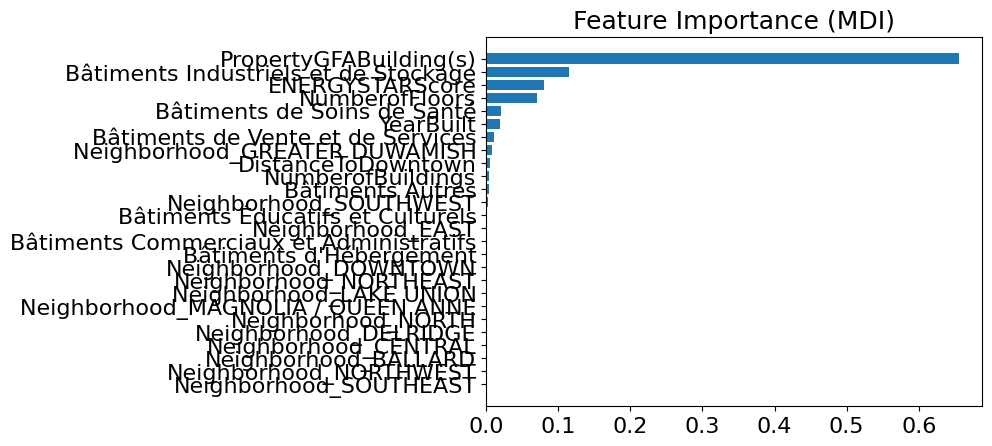

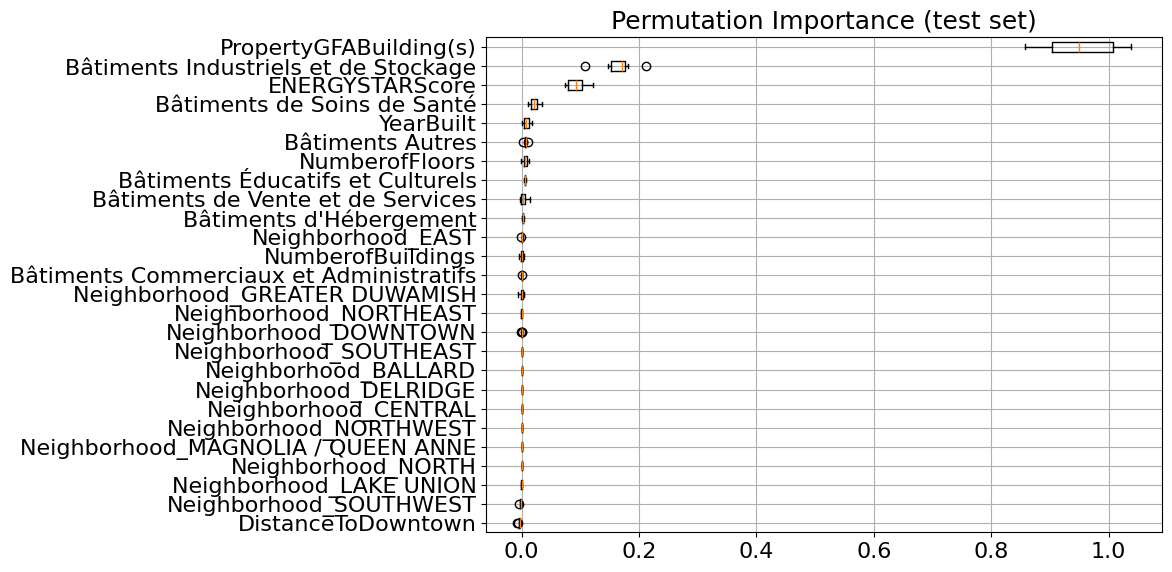

In [27]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title("Feature Importance (MDI)")
fig.tight_layout()
plt.show()

result = permutation_importance(
    reg, X_test_preprocessed, y_test, n_repeats=10, random_state=42, n_jobs=6
)
sorted_idx = result.importances_mean.argsort()

fig = plt.figure(figsize=(12, 6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(feature_names)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
plt.grid()
fig.tight_layout()
plt.show()

In [28]:
import lime
import lime.lime_tabular

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_preprocessed, feature_names=feature_names, mode='regression')

# Choose an instance to explain (e.g., the first instance in your test set)
instance_to_explain = X_test_preprocessed[0]

# Explain the instance
explanation = explainer.explain_instance(instance_to_explain, reg.predict, num_features=len(feature_names))

explanation.save_to_file('local_feature_importance_energy.html')

# Visualize the explanation
explanation.show_in_notebook()


/Users/anthonydavid/miniconda3/envs/OC-env-2/lib/python3.10/site-packages/lime/explanation.py:251: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/anthonydavid/miniconda3/envs/OC-env-2/lib/python3.10/site-packages/lime/bundle.js' mode='r' encoding='utf8'>
  encoding="utf8").read()
/Users/anthonydavid/miniconda3/envs/OC-env-2/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
